![UVic logo](https://res-2.cloudinary.com/crunchbase-production/image/upload/c_lpad,h_256,w_256,f_auto,q_auto:eco/v1406151713/wptak6xuezyh36b1hbty.png)

# **ECE 471/536 Spring 2023: Computer Vision**
## Assignment 3: Gaussian Mixture Model, Super Pixels
### Due date: TBD


> Student: Hang Ruan, V00923058
---

## **1. Instructions:** follow the intructions provided on a sequential manner. 
### 1.0 **Identification** 
Please enter your name and V number on the text code above.

### 1.1 **Submission package**
Your final submission package must be submitted using the [BrightSpace](https://https://bright.uvic.ca/d2l/home)  platform. You will find this assignment's specific page under **Course Tools > Assignments**. Your submission package consists of a *.zip* file containing:

1.   *.ipynb* file: your modified version of this Google Colab template. Place your complete assignment solution/information in this version.  
2.   *.pdf* file: a document containing a writeup with the answers to mathematical questions. 

### 1.2 **Coding considerations**
* In previous years we asked students to complete assignments offline by installing either MATLAB or a Python environment in their computers. In order to standardize the submissions and guarantee that everyone has access to the same Python environment, all assignments are going to be described (by us) and completed (by you) using the same Google Colab reference template script.
* Google Colab offers a Python environment that can be accessed in your browser and executed using Google Cloud, so no local installation is necessary. It makes the setting-up process significantly easier! Please read [this quick tutorial](https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l01c01_introduction_to_colab_and_python.ipynb) notebook on Google Colab/Python.

### 1.3 **Creating your Google Colab submission file**

* Modify this template with your solutions to the assignment. You will find "**TO-DO**" indicators throughout the assingment highlighting portions of the code you are asked to complete. 
* Only edit the provided templates in the bounds of the START TODO and END TODO flags.
* Colab notebooks are divided into individual cells. You can execute the code inside of a given cell by pressing **CTRL+ENTER**, or that of all cells by pressing **CTRL+F9**. Variables must be "executed" in a cell before being used by subsequent ones (the same goes for libraries imported). Note that some cells of this assignment contain flags that must by changed (and executed) before you move forward.
* If you completed the whole assignment, make sure that simply pressing "**CTRL+F9**" executes all cells correctly. **This is going to be the first marking step we will execute when evaluating your submission**.  

### 1.4 **Use of open source code**

* The use of small segments of freely-available code is permitted. However, it is **extremely important** that you indicate in your in-code comments where these are used, as well as their sources. Failure to do so can be considered plagiarism, which is a serious offence. Learn more about detection mechanisms and consequences of plagiarism at UVic [here](https://www.uvic.ca/library/research/citation/plagiarism/). Note that the programming assignments are designed so that most of their content should be created by you.     
* You can never include too many of these only too few. 
* A number of functions/algorithms are already implemented by libraries we will use (e.g., [OpenCV](https://opencv.org/), [scikit-learn](https://scikit-learn.org/stable/)), however you should not use them unless otherwise instructed to do so. Mannualy coding some of these function is an important part of the learning process.  


In [1]:
# ~~~~~~~START TODO~~~~~~~~~
READ_THE_INSTRUCTIONS_FLAG = True
# ~~~~~~~~END TODO~~~~~~~~~~

## **2. Mathematical and Theoretical Questions  (25 points)**

#### Answer all these questions in a seperate pdf!

1. Comment on what is performed in the two phases of the Expectation Maximization optimization for the Gaussian Mixture Model. (5 points)
2. When modeling the background of the image why could we want to use multiple mixed Gaussians instead of a single Gaussian distrobution? (5 points)
3. Describe possible inputs to a Gaussian Mixture Model for background subtractions where the background subtraction would fail. Explain why it would fail on that input. (5 points)
4. Why would someone want an online Gaussian Mixture Model? Why would someone want a pre-computed Gaussian Mixture Model? Give examples of concrete cases. (5 points)
5. Why does SLIC select the starting clusters not on a perfect grid but instead at the lowest gradient magnitude in a small neighborhood around the grid. (5 points)



# **3. Programming: introduction to Python, Colab and OpenCV**

### **3.1 Basic image operations**


---



---


In [2]:
import sys 
import os
import cv2 # imports OpenCV
import numpy as np
from matplotlib import pyplot as plt #imports matplotlib 
from google.colab.patches import cv2_imshow
from sklearn.mixture import GaussianMixture # Imports the Gaussian Mixture Model for this assignment
%matplotlib inline
# You will NOT need to import any more libraries for ANY assignment. 


def pltImg(img, title=None, ori="horizontal", colorb = True):  # not mandatory, but useful
  plt.imshow(img)
  if colorb:
    plt.colorbar(orientation=ori)
  if title:
    plt.title(title)
  return plt

print('-'*40)
print ('Python version: {}'.format(sys.version))
print('OpenCV version: {}'.format(cv2.__version__))

if not READ_THE_INSTRUCTIONS_FLAG:
  raise Exception('Please go back and read the instructions.')
else:
  print('\nThank you for reading the instructions.')
print('-'*40)


# Here we simply download the needed images 
if os.path.isfile('./super_pixel_target.jpg'):
  print('Image file already downloaded.')
else:
  !wget "https://raw.githubusercontent.com/dash-uvic/ece471_536-S2022/main/images/A1/super_pixel_target.jpg"

# Here we simply download the needed images 
if os.path.isfile('./ECE471_Assignment_3_Video.mp4'):
  print('Image file already downloaded.')
else:
  !wget "https://raw.githubusercontent.com/dash-uvic/ece471_536-S2022/main/images/A3/ECE471_Assignment_3_Video.mp4"

----------------------------------------
Python version: 3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]
OpenCV version: 4.6.0

Thank you for reading the instructions.
----------------------------------------
Image file already downloaded.
Image file already downloaded.


# **Programming: Gaussian Mixture Model Background Subtraction and Superpixeling**
 

In this assingment you will be implementing gaussian mixture models for background modeling and subtraction. These methods generate a set of Gaussian Mixture Models for each pixel value in a video or sequence of images then use this model to predict A) what the background looks like and B) The proababilities new pixels do not fit into this distribution (are foreground). 

The GMM is a model of a set of n gaussians which best fits the distribution of a given dataset (pixel values in our case). So we use Expectation Maximization to generate the sufficient statistics of our n Gaussians fit to our data. 

We will be doing an offline GMM where we collect all our data then fit the GMM to the whole video at once. If we want to be able to subtract backgrounds live we would use an online method such as <https://www.sciencedirect.com/science/article/pii/S1877705811065258?ref=pdf_download&fr=RR-2&rr=79a0da7c7c5dc65c>. In the online methods we update our statistics of our gaussians as we go and can subtract the background of a non-stationary distribution.

An example of using GMM background modelling is if you want a photo of some popular landmark like Big Ben but other turists are walking in front of you and blocking your view so you can never get a clear image. By modeling the distribution of pixels of a video of Big Ben the most probable pixel values are likely of the stationary background, Big Ben. So by only considering these you can generate a model of the background. 

For our example today we are going to be modeling the background of a busy intersection so we can then segment out people and cars from the background. In the provided video we will be processing there is no frame where the intersection is clear, even worse the lighting changes as the sun moves in the timelaps video. 

The steps of the GMM for background subtraction are:
1. Collect video samples
2. Fit Gaussian Mixture models to each pixel's distribution using Expectation Matximization
3. Generating probabilites or log-likelyhoods of pixels in video frames 
4. Threashold these probablities for a binary segmentation of the foregound and background.

Num Frames: 390


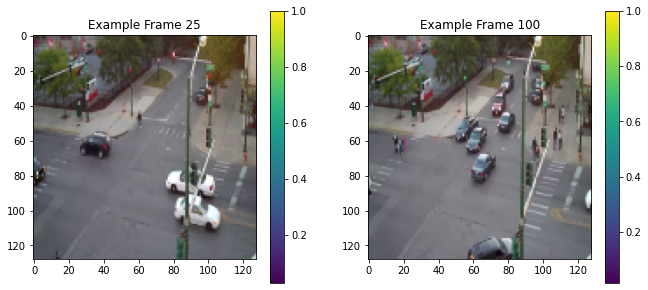

In [3]:
# ~~~~~~~START TODO~~~~~~~~~
# (5 points): Load the video at './ECE471_Assignment_3_Video.mp4' 
# and create a list of every frame of the video
# You should use cv2.VideoCapture to do this.
# Resize each image to 128x128. 
# You may use cv2.resize for this with the default interpolation.
# Convert the color space to RGB in this step from BGR 
# Finally normalize between 0 and 1.

cap = cv2.VideoCapture('./ECE471_Assignment_3_Video.mp4')
frames = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    frame = cv2.resize(frame, (128,128))
    frame = frame[...,::-1] 
    frame = frame/255

    frames.append(frame)
frames = np.array(frames)
cap.release()
cv2.destroyAllWindows()
# ~~~~~~~~END TODO~~~~~~~~~~

print('Num Frames:', len(frames))

plt.figure(figsize = (11,5))
plt.subplot(1, 2, 1)
plt = pltImg(frames[25],title="Example Frame 25", ori='vertical')
plt.subplot(1, 2, 2)
plt = pltImg(frames[100],title = "Example Frame 100", ori='vertical')

In [4]:
def gaussian_mixture_model(frames, n_components):
  # ~~~~~~~START TODO~~~~~~~~~
  # (10 points): Given a list of frames 
  # calulate the gaussian mixture model for each pixel in the video.
  # You should use the skitlearn GaussianMixture object to do this with the provided n_components.
  # See https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
  # This function will likely be quite slow so dont be suprised.
  # Set the tol value in the GaussianMixture to 0.1 to speedup this function.
  # Your means, covariances and weights should be of shape (h,w,c,n_components)
  # Also return a list of all the GaussianMixture models you train with shape (h,w,3)
  means = []
  covariances = []
  weights = []
  models = []
  #print(frames.shape)
  for h in range(128):
    for w in range(128):
      for c in range(3):
        sub_frame = frames[:,h,w,c]
        subframe = [[i] for i in sub_frame]
        #print(sub_frame.shape)
        gm = GaussianMixture(n_components=n_components, tol=0.1).fit(X = subframe)
        mean = gm.means_
        covariance = gm.covariances_
        weight = gm.weights_
        model = gm

        means.append(mean)
        covariances.append(covariance)
        weights.append(weight)
        models.append(gm)
  #Your means, covariances and weights should be of shape (h,w,c,n_components)
  # Also return a list of all the GaussianMixture models you train with shape (h,w,3
  means = np.array(means)
  covariances = np.array(covariances)
  weights = np.array(weights)
  models = np.array(models)

  means = np.reshape(means,(128,128,3,5))
  covariances = np.reshape(covariances,(128,128,3,5))
  weights = np.reshape(weights,(128,128,3,5))
  models = np.reshape(models,(128,128,3))
  # ~~~~~~~~END TODO~~~~~~~~~~
 
  return means, covariances, weights, models


means, covariances, weights, models = gaussian_mixture_model(frames,5)

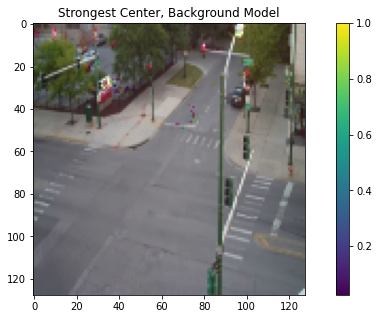

In [5]:
def generate_nominal_images(means, covariances, weights, n_components):
  # ~~~~~~~START TODO~~~~~~~~~
  # (10 points): Generate the expected background based on your calculated means, covariances and weights.
  # The background image should contain the values of the centerpoint of the strongest Gaussian component 
  # of the GMM of a particular pixel.
  strongest_center = np.zeros((128,128,3))
  for h in range(128):
    for w in range(128):
      for c in range(3):
        index = np.argmax(weights[h,w,c,:])
        strongest_center[h,w,c] = means[h,w,c,index]

  # ~~~~~~~~END TODO~~~~~~~~~~
  return strongest_center

strongest_center = generate_nominal_images(means, covariances, weights, 5)

plt.figure(figsize = (11,5))
plt.subplot(1, 1, 1)
plt = pltImg(strongest_center,title="Strongest Center, Background Model", ori='vertical')

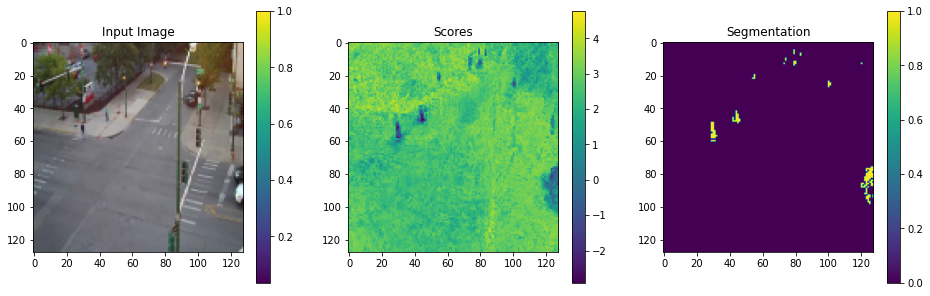

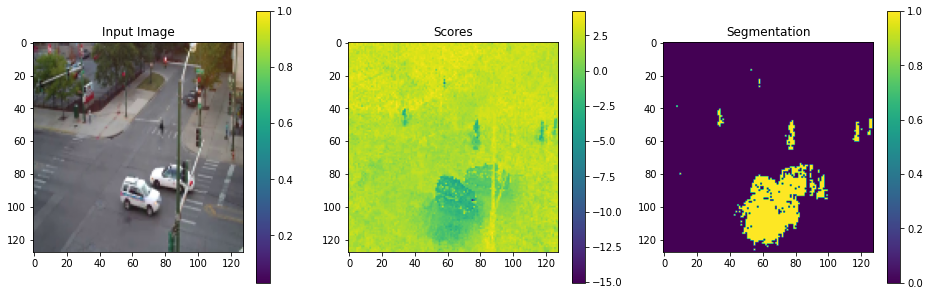

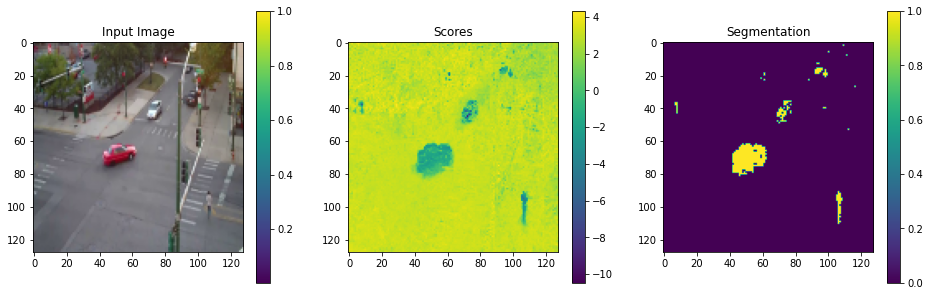

In [6]:
def segment_image_foreground(image, models, threshold):
  # ~~~~~~~START TODO~~~~~~~~~
  # (10 points): Return a binary single channel image with values of 1 where 
  # the score of an image pixel is less than the threashold 
  # (averaged over the color channels) and 0 otherwise.
  # Use the GaussianMixture.score method to generate these scores
  # Return both the scores and the binary segmentation based on the threashold.
  scores = np.zeros((128,128))
  output = np.zeros((128,128))
  for h in range(128):
    for w in range(128):
      score = []
      for c in range(3):
        gm = models[h,w,c]
        x = [[image[h,w,c]]]
        score.append(gm.score(x))
      scores[h,w] = sum(score)/len(score)
      if scores[h,w] < threshold:
        output[h,w] = 1
      else:
        output[h,w] = 0
  # ~~~~~~~~END TODO~~~~~~~~~~
  return scores, output


for x in [15,30,45]:
  scores, segmentation = segment_image_foreground(frames[x], models, 0)
  plt.figure(figsize = (16,5))
  plt.subplot(1, 3, 1)
  plt = pltImg(frames[x],title="Input Image", ori='vertical')
  plt.subplot(1, 3, 2)
  plt = pltImg(scores,title = "Scores", ori='vertical')
  plt.subplot(1, 3, 3)
  plt = pltImg(segmentation,title = "Segmentation", ori='vertical')
  plt.show()

# **Superpixeling**

In this section we will be doing superpixeling based on the SLIC algorithm.

You can see the details of this algorithm in https://www.iro.umontreal.ca/~mignotte/IFT6150/Articles/SLIC_Superpixels.pdf.


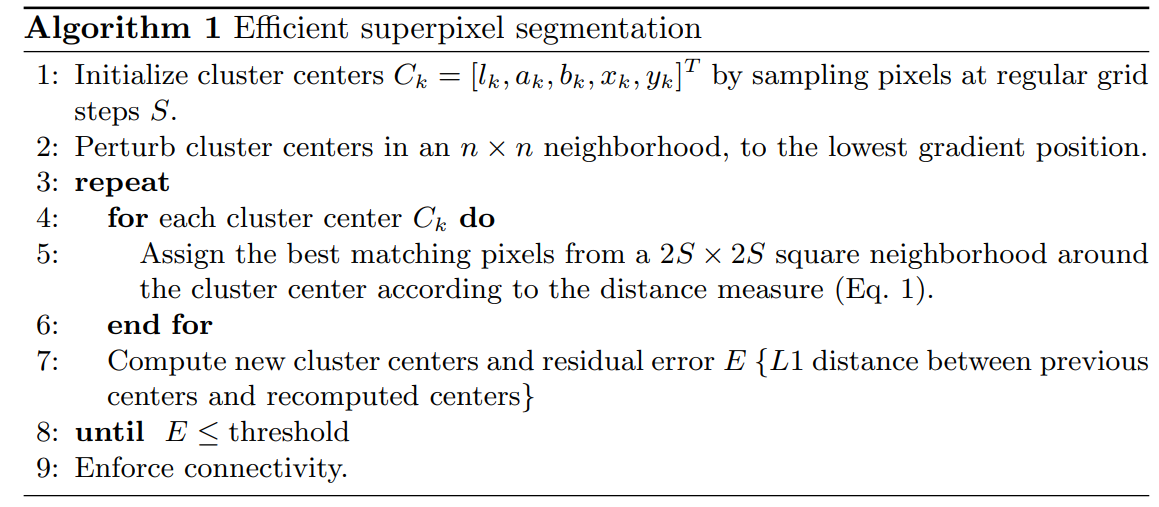


In [ ]:
from scipy import show_numpy_config
# ~~~~~~~START TODO~~~~~~~~~
# (5 points): Load the image at './super_pixel_target.jpg'
# Resize the image to (256,128)
# Generate the Gradients for the image with cv2.Laplacian(,cv2.CV_64F) and 
# take the absolute value of these gradients and sum them along the color channels.
# Convert the image to the LAB color space using cv2.cvtColor
height = 128
width = 256
img = cv2.imread('./super_pixel_target.jpg')
img = cv2.resize(img,(width,height))
img_laplacian = cv2.Laplacian(img,cv2.CV_64F)
img_absolute = np.absolute(img_laplacian)
gradients = np.zeros((height,width))


for h in range(height):
  for w in range(width):
    colors = [i for i in img_absolute[h,w]]
    the_avg = sum(colors)/len(colors)
    gradients[h,w] = the_avg
LAB = cv2.cvtColor(img,cv2.COLOR_BGR2LAB)
# ~~~~~~~~END TODO~~~~~~~~~~


plt.figure(figsize = (20,5))
plt.subplot(1, 2, 1)
plt = pltImg(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),title="Image", ori='vertical')
plt.subplot(1, 2, 2)
plt = pltImg(gradients,title = "Gradients", ori='vertical')


In [ ]:

def generate_intial_clusters(LAB, gradients, n_super_pixels, init_r):
  # ~~~~~~~START TODO~~~~~~~~~
  # (10 points): Generate the intial cluster centers for your method.
  # Each cluster center should be a list of the [L,A,B,x,y] where LAB are the 
  # LAB color information of that starting cluster pixel and 
  # the x,y are the inital center point of that cluster.
  # You sould derive the spaceing of these cluster centers 
  # from the desired number of pixels where spacing = sqrt(n/n_super_pixels) where
  # n is the number of pixels in the image. 
  # Once you have the equally spaced gid of pixels you should move the pixel up to 
  # init_r pixels to the minium gradient value in that neighborhood. 
  S = int(np.sqrt(gradients.shape[0]*gradients.shape[1]/n_super_pixels))
  height = gradients.shape[0]
  width = gradients.shape[1]
  grid = []
  lab = []

  for i in range(0,height,S):
    for j in range(0,width,S):
      grid.append((i,j))
      lab.append(LAB[i,j])


  updated_grid = []
  for (i,j) in grid:
    lowest_cord = (i,j)
    lowerst_x_y_gradient = gradients[i,j]
    for x in range( max(0,i-init_r) , min(i+init_r+1,height) ):
      for y in range( max(0,j-init_r) , min(j+init_r+1,width) ):
        if gradients[x,y] <= lowerst_x_y_gradient:
          lowest_cord = (x,y)
          lowerst_x_y_gradient = gradients[x,y]
    updated_grid.append(lowest_cord)

  centers = []
  for m,n in zip(lab,updated_grid):
    centers.append((m[0],m[1],m[2],n[0],n[1]))
  #print(centers)
  # ~~~~~~~~END TODO~~~~~~~~~~
  return centers

centers = generate_intial_clusters(LAB, gradients, 128, 2)
print('Number of Clusters:', len(centers))
pixel_centers_inital = img.copy()
for center in centers:
  pixel_centers_inital[center[3],center[4]] = [255,0,255]
plt.figure(figsize = (20,10))
plt.subplot(1, 1, 1)
plt = pltImg(cv2.cvtColor(pixel_centers_inital,cv2.COLOR_BGR2RGB),title="Super Pixel Centers", ori='vertical')

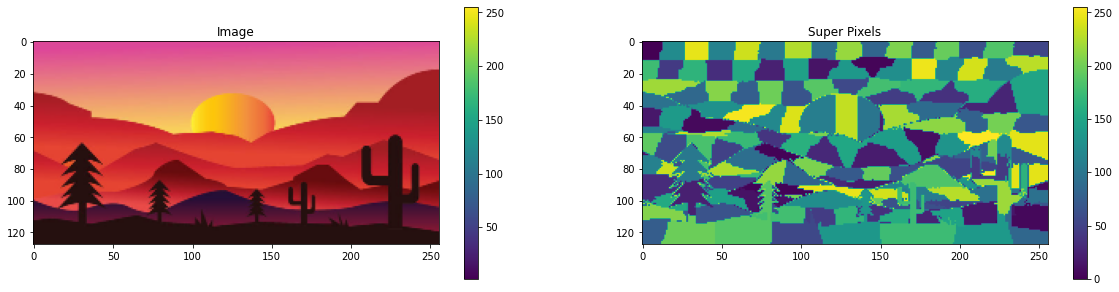

In [9]:
def do_super_pixel_clustering(LAB, init_clusters, itterations, m):
  # ~~~~~~~START TODO~~~~~~~~~
  # (25 points): In this function you will associate each pixel with its closest
  # clusters based on the intial clusters passed from your previous work. 
  # The distance measure is equation 1 in the linked paper. 
  # You do not need to normalize the LAB values or the distances. 
  # This is incoperated into the selection of m.
  # The description of this loop is provided above in Algorithm 1 taken from the 
  # SLIC paper. 
  # Remeber s = sqrt(num_pixels/num_clusters)
  # You do not need to implement the functionality for enforcing connectivitiy. 
  # You also do not need to check the L1 distance between the updates only itterate
  # 'intterations' times.
  # This function should recturn a numpy array of shape (h,w) where
  # the value at each point is the index to the intial_cluster it has been associated to
  # and a new list of cluster centers.
  # You can leave points without a cluster at a value of -1
  height = LAB.shape[0]
  width = LAB.shape[1]
  s = np.sqrt(height*width/len(init_clusters))
  #print("Width:",width)
  #print("Heights:",height)
  

  def distances(LAB,x,y,centroid):
    
    sum1 = 0.
    sum2 = 0.
    sum1 += pow(int(LAB[x,y,0]) - int(centroid[0]),2)
    sum1 += pow(int(LAB[x,y,1]) - int(centroid[1]),2)
    sum1 += pow(int(LAB[x,y,2]) - int(centroid[2]),2)
    sum2 += pow(x - centroid[3],2)
    sum2 += pow(y - centroid[4],2)
  

    return np.sqrt(sum1) + m*np.sqrt(sum2)/s


  cluster_centers = init_clusters.copy()

  for iterations in range(itterations):




    # initialize clusters 
    clusters = [None] * len(init_clusters)
    
    # iterate through all pixels
    for x in range(height):
      for y in range(width):
        distance_list = []
        
        # locate the cluster the pixel belong to 
        for cluster_center in cluster_centers:
          distance_list.append(distances(LAB,x,y,cluster_center))
        cluster_index = np.argmin(distance_list)
      
        # cluster the pixel to right cluster group
        if clusters[cluster_index] == None:
          clusters[cluster_index] = [(LAB[x,y,0],LAB[x,y,1],LAB[x,y,2],x,y)]
        else:
          clusters[cluster_index].append((LAB[x,y,0],LAB[x,y,1],LAB[x,y,2],x,y))

        
    
      
    #for cluster in clusters:
      #print(cluster)




    cluster_centers = []       
    
    for cluster in clusters:
      l = []
      a = []
      b = []
      x = []
      y = []
      for each_pixel in cluster:
        l.append(each_pixel[0])
        a.append(each_pixel[1])
        b.append(each_pixel[2])
        x.append(each_pixel[3])
        y.append(each_pixel[4])
      avg_l = sum(l)/len(l)
      avg_a = sum(a)/len(a)
      avg_b = sum(b)/len(b)
      avg_x = sum(x)/len(x)
      avg_y = sum(y)/len(y)
      cluster_centers.append((avg_l,avg_a,avg_b,avg_x,avg_y))

  # build cluster_association
  cluster_associations = np.zeros((height,width))
  for cluster_index,cluster in enumerate(clusters):
    for each_pixel in cluster:
      cluster_associations[each_pixel[3],each_pixel[4]] = cluster_index

  new_clusters = cluster_centers

  # ~~~~~~~~END TODO~~~~~~~~~~
  return cluster_associations, new_clusters

cluster_associations, new_clusters = do_super_pixel_clustering(LAB, centers, 2, 10)
cluster_associations = (cluster_associations*123)%256

plt.figure(figsize = (20,5))
plt.subplot(1, 2, 1)
plt = pltImg(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),title="Image", ori='vertical')
plt.subplot(1, 2, 2)
plt = pltImg(cluster_associations,title = "Super Pixels", ori='vertical')




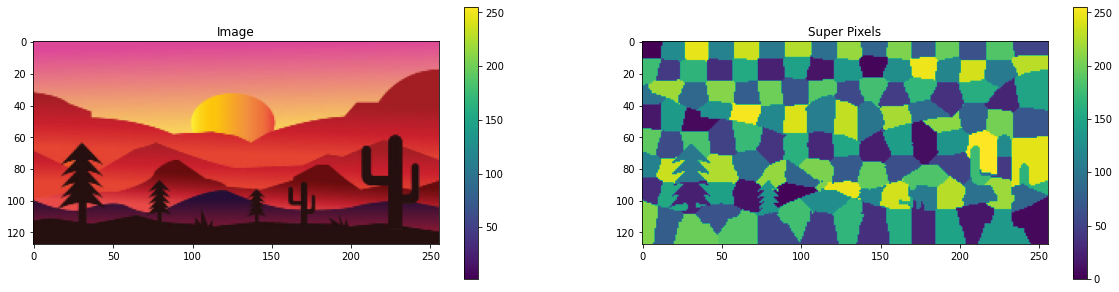

In [10]:
cluster_associations, new_clusters = do_super_pixel_clustering(LAB, centers, 2, 100)
cluster_associations = (cluster_associations*123)%256

plt.figure(figsize = (20,5))
plt.subplot(1, 2, 1)
plt = pltImg(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),title="Image", ori='vertical')
plt.subplot(1, 2, 2)
plt = pltImg(cluster_associations,title = "Super Pixels", ori='vertical')


**End of the assignment!**